# Importation des librairies

In [79]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import boto3
import sagemaker


sm_boto3 = boto3.client('sagemaker')
sess = sagemaker.Session()
region = sess.boto_session.region_name
bucket_name = "LE NOM DE TON BUCKET S3"

print("Utilisation de l'instance SageMaker dans la région {} et le bucket {}".format(region, bucket_name))

Utilisation de l'instance SageMaker dans la région us-east-1 et le bucket finance-test-model


# Charger les données du DataSet

Dataset : https://www.kaggle.com/datasets/krishnaraj30/finance-loan-approval-prediction-data

In [80]:
train_file_path = './datasets/train.csv'
test_file_path = './datasets/test.csv'

df_train = pd.read_csv(train_file_path)

# Analyse du Dataset

In [81]:
info = df_train.info() 
tete = df_train.head() 
data_shape = df_train.shape 

no_of_rows, no_of_columns = (data_shape) 
no_of_features = no_of_columns - 1
tot_num_data = no_of_rows * no_of_columns


print (f'Informations générales sur les données :\n{info}')
print ('-----------------------------------------------------------------------\n')

print (f'Dimensions des données :\n{data_shape}\n')

print (f'Nombre de lignes : {no_of_rows}')
print (f'Nombre de colonnes : {no_of_columns}')
print (f'Nombre de features : {no_of_features}')
print (f'Nombre total de données : {tot_num_data}')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB
Informations générales sur les données :
None
------------------------------------------------------------------

# Données sous forme de Tableau

In [82]:
print("Données vue tableaux")

tete

Données vue tableaux


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


## Gestion des valeurs nuls/Nan dans le Dataset

In [83]:
#Checking for missing values

valeurs_null = df_train.isnull().sum()

print ('Les données manquantes pour chaque colonne: \n', valeurs_null)

Les données manquantes pour chaque colonne: 
 Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64


## Completer les valeurs nulles dans le dataset



2 types de données : 

- Catégorie (Gender, Married, Dependents, Self-employed, Credit history) -> Completer par le mode de la colonne

- Numérique (Loan amount. Loan amount term) -> Completer par la moyenne

# Pourquoi ? 

* Au lieu de supprimer et perdre beaucoup de données -> on complete par des valeurs non impactante

* En régression logistique on ne peut avoir de valeur NaN

Mode = valeur la plus fréquente

on remplace par la valeur deja majoritaire ce qui n'influence pas le jeu de donnée

Moyenne 

On complete par la moyenne ce qui influence que trés peu le jeu de donnée

In [84]:
#Compléter les valeurs manquantes pour les colonnes catégories

df_train['Gender'] = df_train['Gender'].fillna(df_train['Gender'].mode()[0])
df_train['Married'] = df_train['Married'].fillna(df_train['Married'].mode()[0])
df_train['Dependents'] = df_train['Dependents'].fillna(df_train['Dependents'].mode()[0])
df_train['Self_Employed'] = df_train['Self_Employed'].fillna(df_train['Self_Employed'].mode()[0])
df_train['Credit_History'] = df_train['Credit_History'].fillna(df_train['Credit_History'].mode()[0])

In [85]:
#Compléter les valeurs manquantes pour les données numériques

df_train['LoanAmount'] = df_train['LoanAmount'].fillna(df_train['LoanAmount'].mean())
df_train['Loan_Amount_Term'] = df_train['Loan_Amount_Term'].fillna(df_train['Loan_Amount_Term'].mean())


In [86]:
#Double check des valeurs nulles après le remplissage
df_train.isnull().sum()


Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

<Axes: >

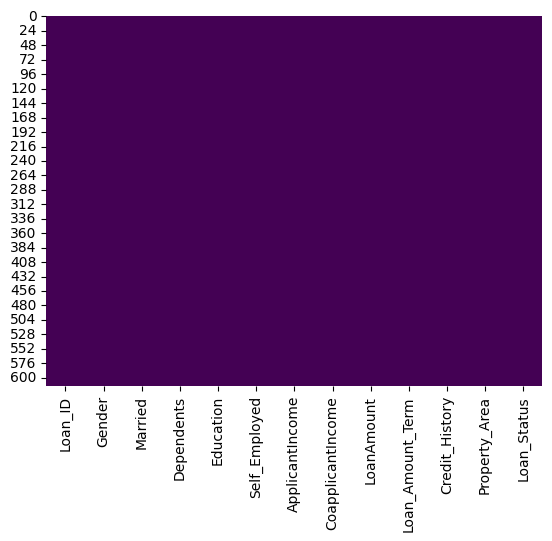

In [87]:
#Visualisation des données manquantes
sns.heatmap(df_train.isnull(), cbar=False, cmap='viridis')

## Exploration des données

## Visualisation des données

### Données numériques

array([[<Axes: xlabel='LoanAmount', ylabel='LoanAmount'>,
        <Axes: xlabel='Loan_Amount_Term', ylabel='LoanAmount'>,
        <Axes: xlabel='ApplicantIncome', ylabel='LoanAmount'>,
        <Axes: xlabel='CoapplicantIncome', ylabel='LoanAmount'>],
       [<Axes: xlabel='LoanAmount', ylabel='Loan_Amount_Term'>,
        <Axes: xlabel='Loan_Amount_Term', ylabel='Loan_Amount_Term'>,
        <Axes: xlabel='ApplicantIncome', ylabel='Loan_Amount_Term'>,
        <Axes: xlabel='CoapplicantIncome', ylabel='Loan_Amount_Term'>],
       [<Axes: xlabel='LoanAmount', ylabel='ApplicantIncome'>,
        <Axes: xlabel='Loan_Amount_Term', ylabel='ApplicantIncome'>,
        <Axes: xlabel='ApplicantIncome', ylabel='ApplicantIncome'>,
        <Axes: xlabel='CoapplicantIncome', ylabel='ApplicantIncome'>],
       [<Axes: xlabel='LoanAmount', ylabel='CoapplicantIncome'>,
        <Axes: xlabel='Loan_Amount_Term', ylabel='CoapplicantIncome'>,
        <Axes: xlabel='ApplicantIncome', ylabel='CoapplicantIncome'

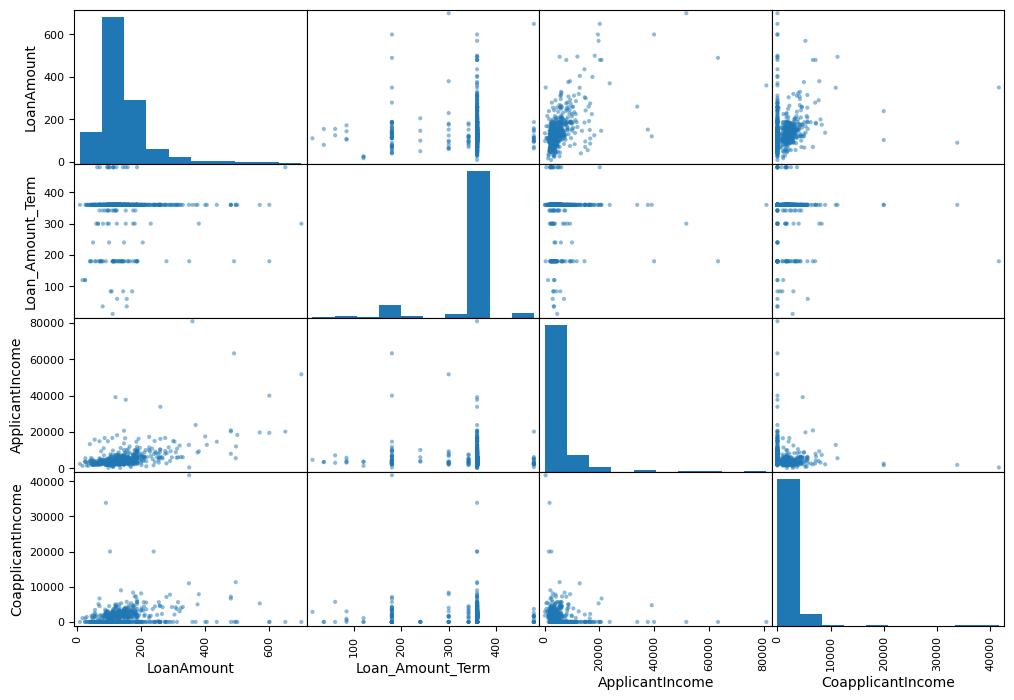

In [88]:
#Using scatterplot to check for outliers
from pandas.plotting import scatter_matrix

num_columns = ['LoanAmount', 'Loan_Amount_Term', 'ApplicantIncome', 'CoapplicantIncome']
scatter_matrix(df_train[num_columns], figsize = (12, 8))

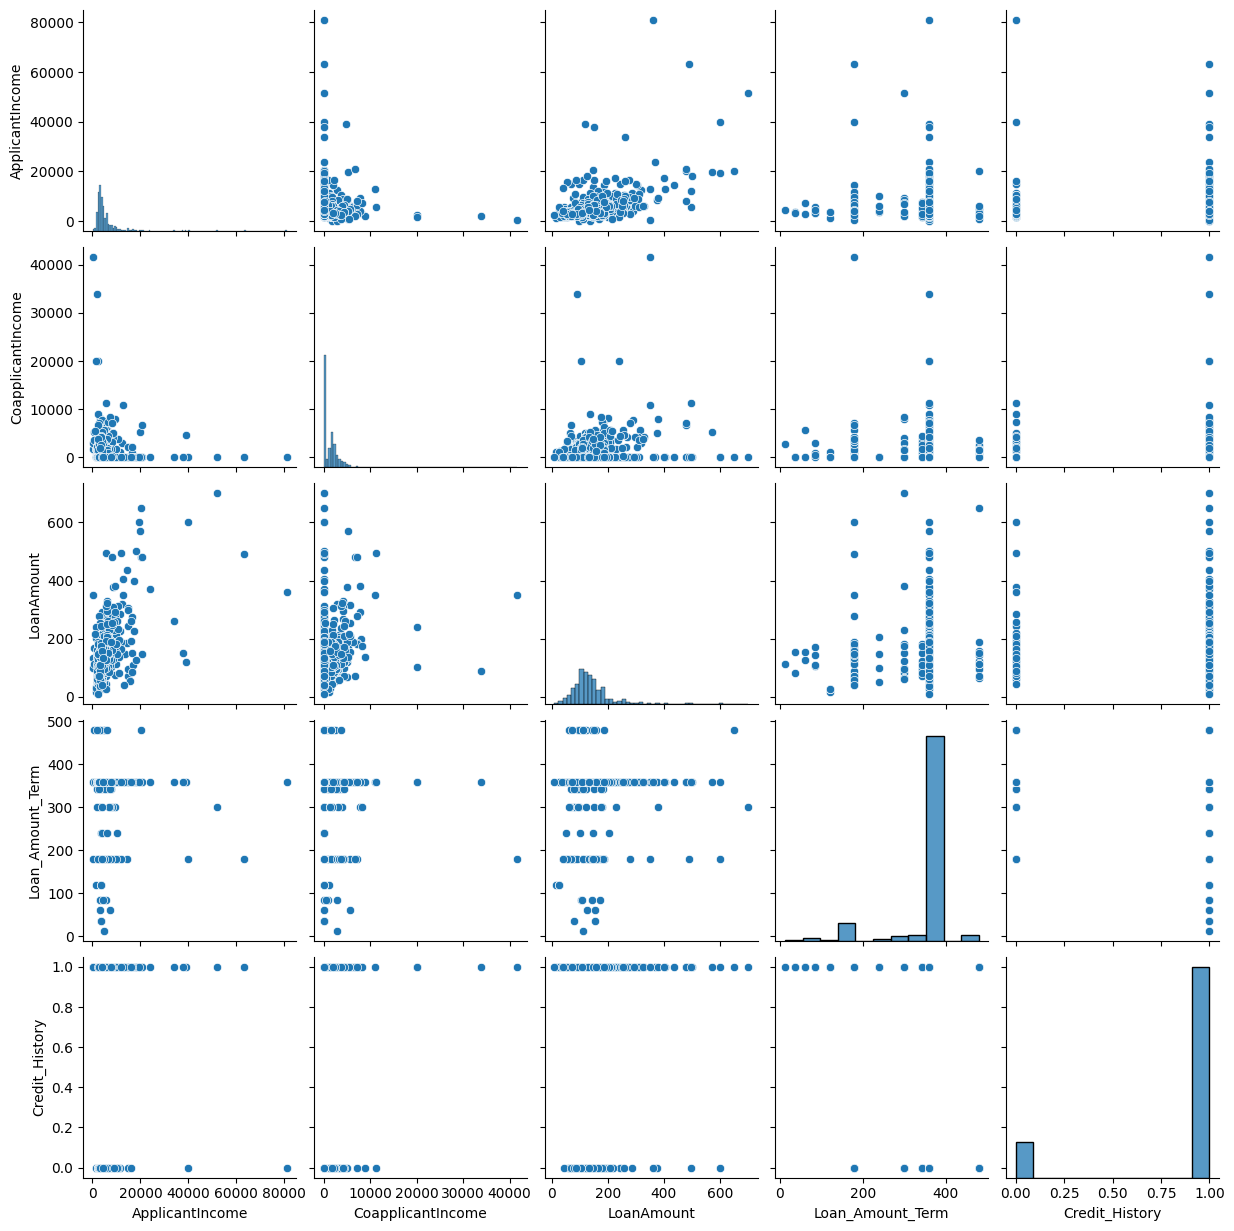

In [89]:
sns.pairplot(df_train)

<Axes: >

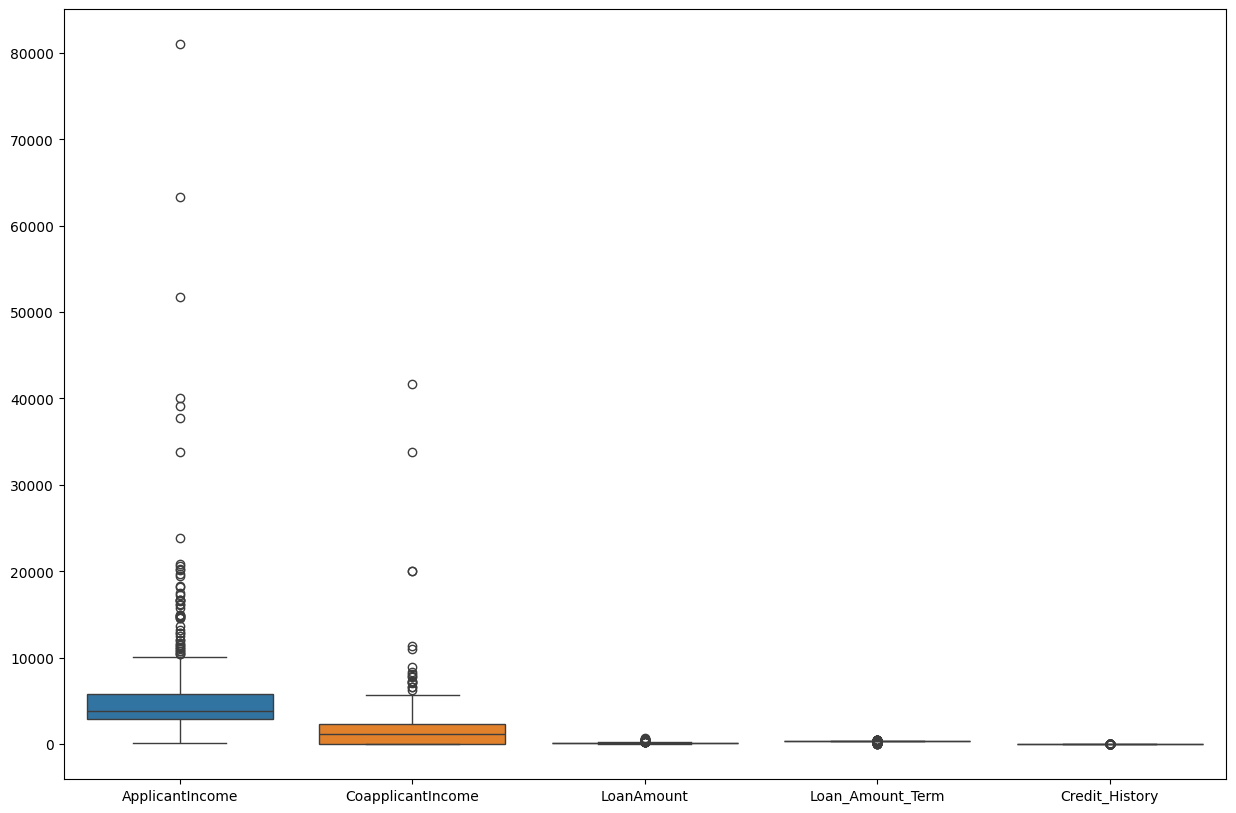

In [90]:
#Further examination of numerical outliers
plt.figure(figsize = (15,10))
sns.boxplot(data=df_train)


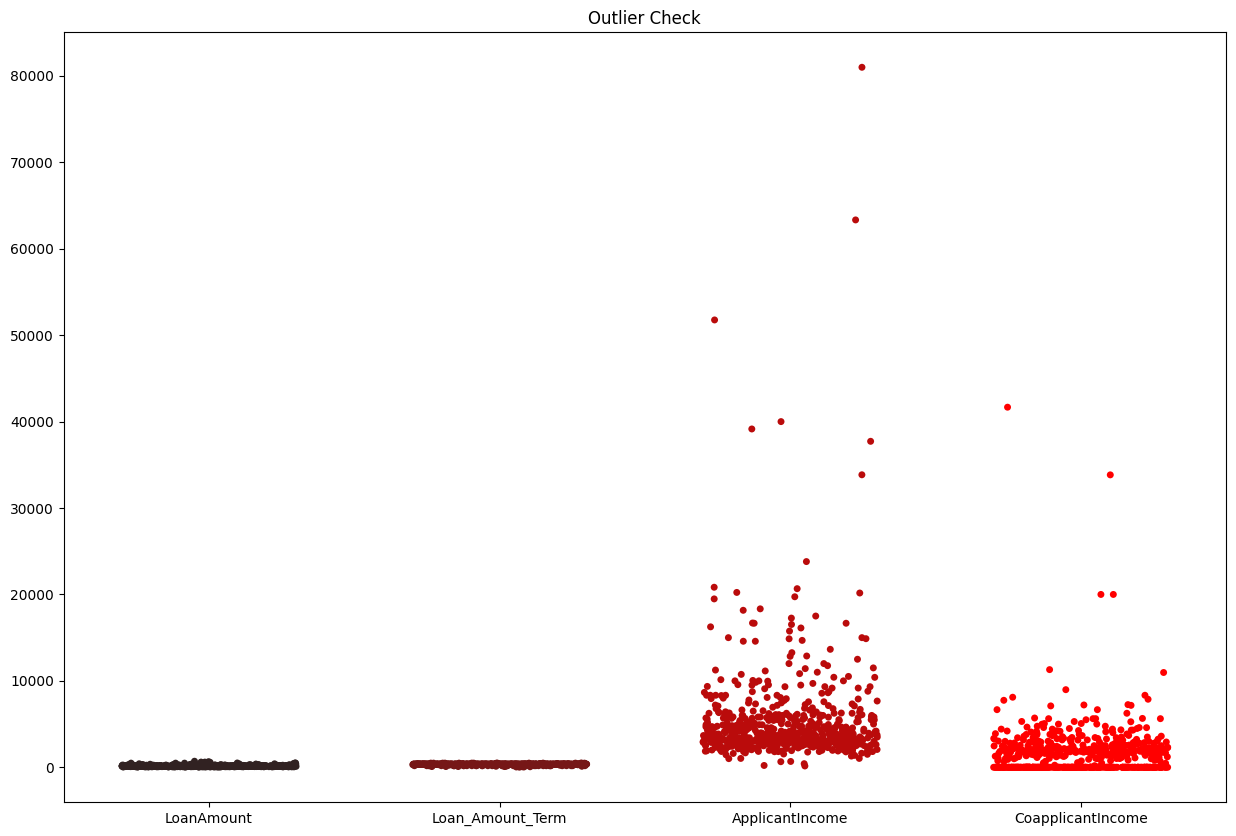

In [91]:
plt.figure(figsize = (15, 10))

Outlier_check = df_train[num_columns]
sns.stripplot(data = Outlier_check, palette='dark:red', jitter = 0.3, size = 5)

plt.title('Outlier Check')


plt.show()

### Données catégories

C:\Users\benoi\AppData\Local\Temp\ipykernel_27828\2916519445.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation = 45)
C:\Users\benoi\AppData\Local\Temp\ipykernel_27828\2916519445.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation = 45)
C:\Users\benoi\AppData\Local\Temp\ipykernel_27828\2916519445.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation = 45)
C:\Users\benoi\AppData\Local\Temp\ipykernel_27828\2916519445.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].se

[12/27/24 10:53:48] INFO     Using categorical units to plot a list of strings that are all         category.py:224
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

                    INFO     Using categorical units to plot a list of strings that are all         category.py:224
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

C:\Users\benoi\AppData\Local\Temp\ipykernel_27828\2916519445.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation = 45)
C:\Users\benoi\AppData\Local\Temp\ipykernel_27828\2916519445.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation = 45)
C:\Users\benoi\AppData\Local\Temp\ipykernel_27828\2916519445.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation = 45)


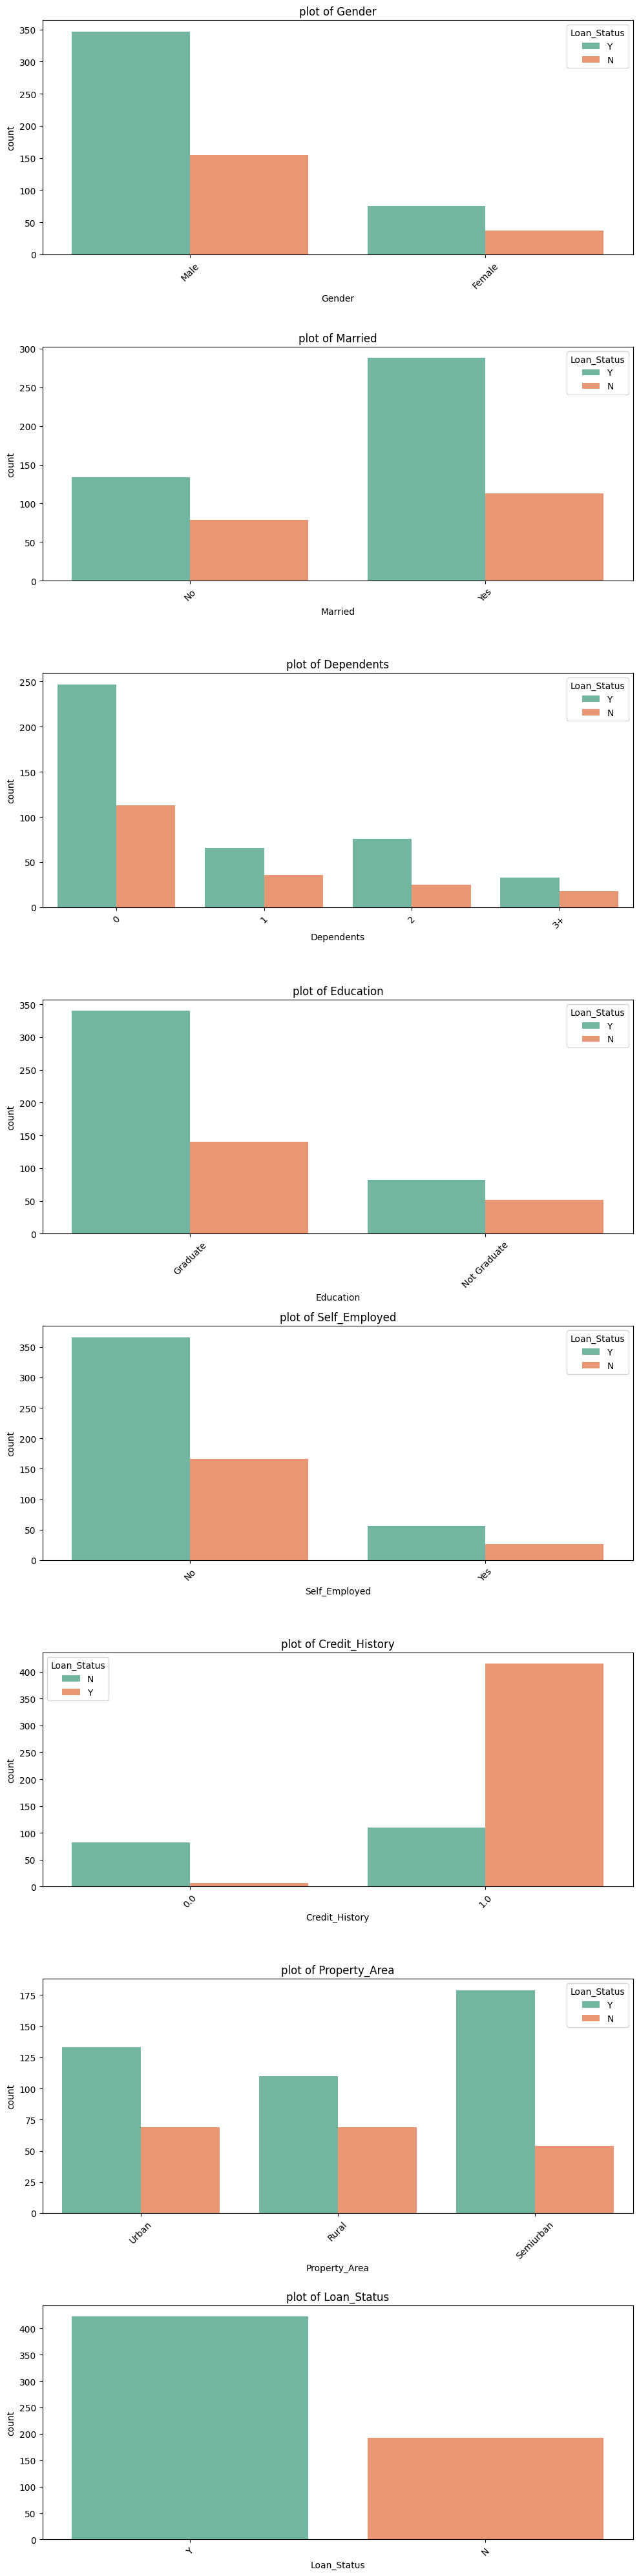

In [92]:
# Visualisng all categorical columns at once
cat_columns = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History', 'Property_Area', 'Loan_Status']


#setting up plotting environment
num_cat = len(cat_columns)

fig, axes = plt.subplots(nrows=num_cat, ncols=1, figsize = (10, 5*num_cat))

#Plotting barchat of each categorical columns
for i, col in enumerate(cat_columns):
    sns.countplot(data=df_train, x=col, ax=axes[i], hue='Loan_Status', palette='Set2')
    axes[i].set_title(f'plot of {col}')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation = 45)

plt.tight_layout()
plt.show()

In [93]:
dependents_0 = df_train[df_train['Dependents'] == '0']
total_dependents_0 = len(dependents_0)
loan_status_no = dependents_0[dependents_0['Loan_Status'] == 'No']
percent_loan_status_no = (len(loan_status_no)/total_dependents_0)*100

percent_loan_status_no

0.0

In [94]:
# Step 1: Filter rows where Dependents is '0'
dependents_zero = df_train[df_train['Dependents'] == '0']

# Step 2: Calculate the total number of Dependents '0'
total_dependents_zero = len(dependents_zero)
total_dependents_notzero = len(df_train[df_train['Dependents'] != '0'])

# Step 3: Filter rows where Loan_Status is 'No' from the dependents_zero subset
loan_status_no = dependents_zero[dependents_zero['Loan_Status'] == 'N']

# Step 4: Calculate the percentage of Loan_Status 'No' in Dependents '0'
percentage_no_loan = (len(loan_status_no) / total_dependents_zero) * 100

print(f"Total number of Dependents '0': {total_dependents_zero}")
print(f"Total number of Dependents not '0': {total_dependents_notzero}")
print(f"Percentage of Dependents '0' with Loan_Status 'No': {percentage_no_loan:.2f}%")
print (len(df_train['Dependents']))
print (len(loan_status_no))

Total number of Dependents '0': 360
Total number of Dependents not '0': 254
Percentage of Dependents '0' with Loan_Status 'No': 31.39%
614
113


## Gestions des données improbables/aberrantes

Nous utilisons l'amplitude interquartile (IQR) pour identifier les valeurs aberrantes.

Conventionnellement, les valeurs situées en dehors de 1,5 × IQR sont généralement considérées comme des valeurs aberrantes.

In [95]:
#Calcul IQR pour Applicantincome

Q1_app = df_train['ApplicantIncome'].quantile(0.25)
Q3_app = df_train['ApplicantIncome'].quantile(0.75)
IQR = Q3_app - Q1_app

lowerbound_app = Q1_app - 1.5*IQR
upperbound_app = Q3_app + 1.5*IQR

outliers_app = df_train[(df_train['ApplicantIncome'] < lowerbound_app) | (df_train['ApplicantIncome'] > upperbound_app)]

#Calcul IQR pour CoapplicantIncome

Q1_co = df_train['CoapplicantIncome'].quantile(0.25)
Q3_co = df_train['CoapplicantIncome'].quantile(0.75)
IQR_co = Q3_co - Q1_co

lowerbound_co = Q1_co - 1.5*IQR_co
upperbound_co = Q3_co + 1.5*IQR_co

outliers_co = df_train[(df_train['CoapplicantIncome'] < lowerbound_co) | (df_train['CoapplicantIncome'] > upperbound_co)]

#Suppression des données improbables
df_train = df_train[~((df_train['ApplicantIncome'] < lowerbound_app) | (df_train['ApplicantIncome'] > upperbound_app))]
df_train = df_train[~((df_train['CoapplicantIncome'] < lowerbound_co) | (df_train['CoapplicantIncome'] > upperbound_co))]

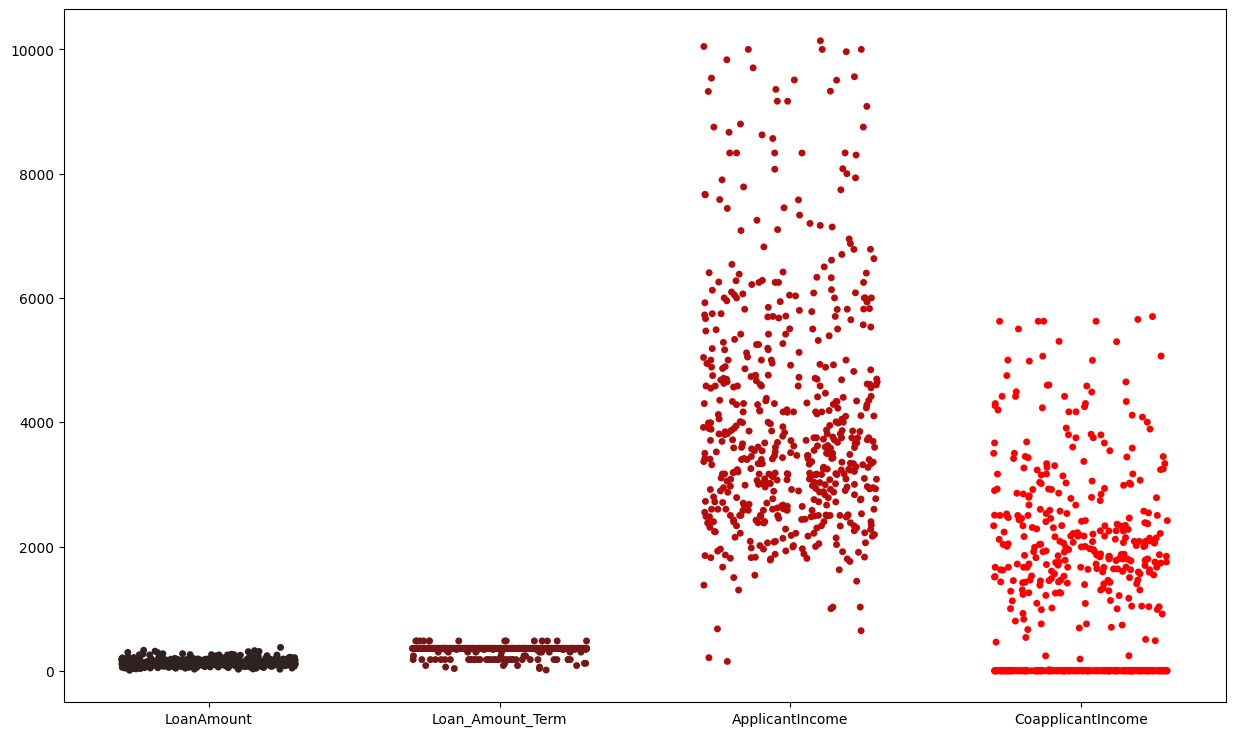

Dimension du dataset après avoir traité les données improbables :  (548, 13)


In [96]:
plt.figure(figsize = (15, 9))

outlier_check2 = df_train[num_columns]
sns.stripplot(data=outlier_check2, palette='dark:red', jitter = 0.3, size = 5)
plt.show()

print ('Dimension du dataset après avoir traité les données improbables : ', df_train.shape)

### Obervations de corrélations

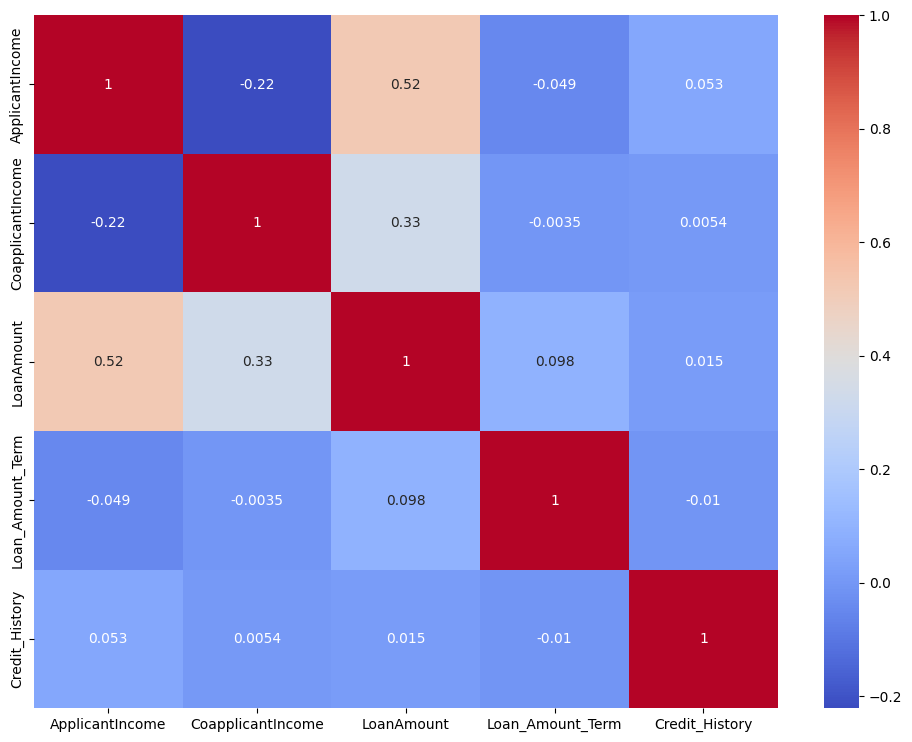

In [97]:
#Selection des colonnes numériques uniquement
numeric_df = df_train.select_dtypes(include=[np.number]) 

plt.figure(figsize=(12, 9))

sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.show()

* On peut observer que Applicant Income est corréléer à Loan_Status
* CoApplicant aussi mais légérement moins corréler

#### Rappel 

Plus la valeur est proche de 1 plus la variable est corrélée et inversement

# Feature Engineering (ou l'art de combiner des variables)

## OneHotEncoding des valeurs de Catégories

Les valeurs de catégories vont être convertis en valeurs numériques faciliter le modèle (et faire la Régression Logistique)

In [98]:
df_train = pd.get_dummies(df_train, columns = cat_columns, drop_first=True)

## Normalisation des features (valeurs X)

- Simplifie les calculs (+ rapide)


### !!! Veiller à "dé-normaliser" aussi les valeurs tests pour obtenir les bonnes valeurs !!!


In [99]:
df_train.head()[["ApplicantIncome","CoapplicantIncome","LoanAmount"]]

,ApplicantIncome,CoapplicantIncome,LoanAmount
0,5849,0.0,146.412162
1,4583,1508.0,128.000000
2,3000,0.0,66.000000
3,2583,2358.0,120.000000
4,6000,0.0,141.000000


In [100]:
max_income = df_train['ApplicantIncome'].max()
max_co_income = df_train['CoapplicantIncome'].max()
max_loan_amount = df_train['LoanAmount'].max()

min_income = df_train['ApplicantIncome'].min()
min_co_income = df_train['CoapplicantIncome'].min()
min_loan_amount = df_train['LoanAmount'].min()

print("-------------------------------------------------")
print(f"Maximum ApplicantIncome: {max_income}")
print(f"Minimum ApplicantIncome: {min_income}")
print("-------------------------------------------------")
print(f"Maximum CoapplicantIncome: {max_co_income}")
print(f"Minimum CoapplicantIncome: {min_co_income}")
print("-------------------------------------------------")
print(f"Maximum LoanAmount: {max_loan_amount}")
print(f"Minimum LoanAmount: {min_loan_amount}")

-------------------------------------------------
Maximum ApplicantIncome: 10139
Minimum ApplicantIncome: 150
-------------------------------------------------
Maximum CoapplicantIncome: 5701.0
Minimum CoapplicantIncome: 0.0
-------------------------------------------------
Maximum LoanAmount: 376.0
Minimum LoanAmount: 9.0


In [101]:
from sklearn.preprocessing import StandardScaler

standard_scaler= StandardScaler()

df_train[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']] = standard_scaler.fit_transform(df_train[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']])

In [102]:
df_train.head()

,Loan_ID,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Credit_History_1.0,Property_Area_Semiurban,Property_Area_Urban,Loan_Status_Y
0,LP001002,0.902588,-0.933096,0.295309,360.0,True,False,False,False,False,False,False,True,False,True,True
1,LP001003,0.238250,0.101980,-0.061506,360.0,True,True,True,False,False,False,False,True,False,False,False
2,LP001005,-0.592435,-0.933096,-1.263023,360.0,True,True,False,False,False,False,True,True,False,True,True
3,LP001006,-0.811258,0.685412,-0.216540,360.0,True,True,False,False,False,True,False,True,False,True,True
4,LP001008,0.981826,-0.933096,0.190425,360.0,True,False,False,False,False,False,False,True,False,True,True


In [103]:
import json

scaler_params = {
    'mean': standard_scaler.mean_.tolist(),
    'scale': standard_scaler.scale_.tolist()
}

scaler_params

{'mean': [4128.978102189781, 1359.4250364756203, 131.17380153876505],
 'scale': [1905.655839429723, 1456.8974252012233, 51.601454554062066]}

In [104]:
with open('scaler_params.json', 'w') as f:
    json.dump(scaler_params, f)
    
s3_client = boto3.client('s3')
s3_client.upload_file('scaler_params.json', bucket_name, 'scalers/scaler_params.json')
s3_client.close()

## Création de nouvelles features

Combiner des valeurs pour créer de nouvelles variables

Nouvelles relations :

* Total Income = Applicant Income + Co-applicant income
* Loan-to-income ratio = Loan amount / Total income

### Pourquoi ?

- Permet de réduire le nombre de données 
- éviter le over-fitting

over-fitting : quand le modèle apprend trop précisement les données et donc évite la généralisation

In [105]:
#Total Income

df_train['Total_Income'] = df_train['ApplicantIncome'] + df_train['CoapplicantIncome']

#Loan-to-income Ratio

df_train['Loan_to_Income'] = df_train['LoanAmount']/df_train['Total_Income'] 

# Viewing the updated features
df_train.head()

,Loan_ID,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Credit_History_1.0,Property_Area_Semiurban,Property_Area_Urban,Loan_Status_Y,Total_Income,Loan_to_Income
0,LP001002,0.902588,-0.933096,0.295309,360.0,True,False,False,False,False,False,False,True,False,True,True,-0.030508,-9.679709
1,LP001003,0.238250,0.101980,-0.061506,360.0,True,True,True,False,False,False,False,True,False,False,False,0.340230,-0.180778
2,LP001005,-0.592435,-0.933096,-1.263023,360.0,True,True,False,False,False,False,True,True,False,True,True,-1.525531,0.827923
3,LP001006,-0.811258,0.685412,-0.216540,360.0,True,True,False,False,False,True,False,True,False,True,True,-0.125846,1.720681
4,LP001008,0.981826,-0.933096,0.190425,360.0,True,False,False,False,False,False,False,True,False,True,True,0.048730,3.907770


## Pourcentage de répartition des classes 


In [106]:
df_train['Loan_Status_Y'].value_counts(normalize=True)*100

Loan_Status_Y
True     69.343066
False    30.656934
Name: proportion, dtype: float64

### Pourquoi ? 

Les données de la vie réelle sont un gros bordel. 

Donc ca nous permet d'identifier : 

- Un déséquilibre des classes
- ajuster les techniques de modélisations
- savoir quel métriques(valeurs) d'évaluation

Dans ce cas présent la répartition est bonne.

Pas besoin donc de rajouter des valeurs ou de les corriger pour l'overfitting ou underfitting

In [107]:
# On va supprimer les colonnes Loan_ID et Loan_Amount_Term

df_train = df_train.drop(['Loan_ID', 'Loan_Amount_Term'], axis=1)

column_update = {'Gender_Male': 'Gender', 'Married_Yes': 'Married',
                'Self_Employed_Yes': 'Self_Employed', 'Loan_Status_Y': 'Loan_Status' }

df_train.rename(columns=column_update, inplace=True)

#Display updated dataset
df_train.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Gender,Married,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed,Credit_History_1.0,Property_Area_Semiurban,Property_Area_Urban,Loan_Status,Total_Income,Loan_to_Income
0,0.902588,-0.933096,0.295309,True,False,False,False,False,False,False,True,False,True,True,-0.030508,-9.679709
1,0.238250,0.101980,-0.061506,True,True,True,False,False,False,False,True,False,False,False,0.340230,-0.180778
2,-0.592435,-0.933096,-1.263023,True,True,False,False,False,False,True,True,False,True,True,-1.525531,0.827923
3,-0.811258,0.685412,-0.216540,True,True,False,False,False,True,False,True,False,True,True,-0.125846,1.720681
4,0.981826,-0.933096,0.190425,True,False,False,False,False,False,False,True,False,True,True,0.048730,3.907770


# Construction du modèle

## Préparation des données

1. Séparer le Dataset en Features (X) and Targets (Y)

2. Train-Test Split: Split data into training and test sets (80% train, 20% test).

In [111]:
features = list(df_train.columns)
print(features)
label = features.pop(-1)

X = df_train[features] #Features

Y = df_train["Loan_Status"] #Target

print ('Shape of X: ', X.shape)
print ('Shape of Y: ', Y.shape)

X.head()

['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Gender', 'Married', 'Dependents_1', 'Dependents_2', 'Dependents_3+', 'Education_Not Graduate', 'Self_Employed', 'Credit_History_1.0', 'Property_Area_Semiurban', 'Property_Area_Urban', 'Loan_Status', 'Total_Income', 'Loan_to_Income']
Shape of X:  (548, 15)
Shape of Y:  (548,)


,ApplicantIncome,CoapplicantIncome,LoanAmount,Gender,Married,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed,Credit_History_1.0,Property_Area_Semiurban,Property_Area_Urban,Loan_Status,Total_Income
0,0.902588,-0.933096,0.295309,True,False,False,False,False,False,False,True,False,True,True,-0.030508
1,0.238250,0.101980,-0.061506,True,True,True,False,False,False,False,True,False,False,False,0.340230
2,-0.592435,-0.933096,-1.263023,True,True,False,False,False,False,True,True,False,True,True,-1.525531
3,-0.811258,0.685412,-0.216540,True,True,False,False,False,True,False,True,False,True,True,-0.125846
4,0.981826,-0.933096,0.190425,True,False,False,False,False,False,False,True,False,True,True,0.048730


## Documentation de Scikit-Learn

Documentation : https://scikit-learn.org/0.21/tutorial/basic/tutorial.html

Vidéo sur le sujet : https://www.youtube.com/watch?v=0B5eIE_1vpU&pp=ygUSc2Npa2l0IGxlYXJuIGJhc2lj

Livre Hands on Machine Learning: https://www.amazon.fr/Hands-Machine-Learning-Scikit-learn-Tensorflow/dp/1098125975/ref=asc_df_1098125975?mcid=c65f200626d13a1ab3d5944cd898aebd&tag=googshopfr-21&linkCode=df0&hvadid=701510839370&hvpos=&hvnetw=g&hvrand=15667932878931070552&hvpone=&hvptwo=&hvqmt=&hvdev=c&hvdvcmdl=&hvlocint=&hvlocphy=9109552&hvtargid=pla-1651497364252&psc=1&gad_source=1

In [112]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 42)

In [113]:
X_test.isnull().sum()

ApplicantIncome            0
CoapplicantIncome          0
LoanAmount                 0
Gender                     0
Married                    0
Dependents_1               0
Dependents_2               0
Dependents_3+              0
Education_Not Graduate     0
Self_Employed              0
Credit_History_1.0         0
Property_Area_Semiurban    0
Property_Area_Urban        0
Loan_Status                0
Total_Income               0
dtype: int64

In [114]:
X_train.isnull().sum()

ApplicantIncome            0
CoapplicantIncome          0
LoanAmount                 0
Gender                     0
Married                    0
Dependents_1               0
Dependents_2               0
Dependents_3+              0
Education_Not Graduate     0
Self_Employed              0
Credit_History_1.0         0
Property_Area_Semiurban    0
Property_Area_Urban        0
Loan_Status                0
Total_Income               0
dtype: int64

## Importation des données sur S3

In [115]:
X_train.to_csv('train-V-1.csv', index=False)
X_test.to_csv('test-V-1.csv', index=False)


In [116]:
sk_prefix = "sagemaker/finance-loan-prediction/sklearncontainer"

train_path_s3 = sess.upload_data(path="train-V-1.csv", bucket=bucket_name, key_prefix=sk_prefix)

test_path_s3 = sess.upload_data(path="test-V-1.csv", bucket=bucket_name, key_prefix=sk_prefix)

In [117]:
print(f"Training data uploaded to: {train_path_s3}")
print(f"Test data uploaded to: {test_path_s3}")

Training data uploaded to: s3://finance-test-model/sagemaker/finance-loan-prediction/sklearncontainer/train-V-1.csv
Test data uploaded to: s3://finance-test-model/sagemaker/finance-loan-prediction/sklearncontainer/test-V-1.csv


In [118]:
%%writefile script.py


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc
import sklearn
import joblib
import boto3
import pathlib
from io import StringIO 
import argparse
import joblib
import os
import numpy as np
import pandas as pd

# inference functions ---------------

# def input_fn(request_body, request_content_type):
#     print(request_body)
#     print(request_content_type)
#     if request_content_type == "text/csv":
#         request_body = request_body.strip()
#         try:
#             df = pd.read_csv(StringIO(request_body), header=None)
#             return df
        
#         except Exception as e:
#             print(e)
#     else:
#         return """Please use Content-Type = 'text/csv' and, send the request!!""" 
 
    
def model_fn(model_dir):
    clf = joblib.load(os.path.join(model_dir, "model.joblib"))
    return clf

# def predict_fn(input_data, model):
#     if type(input_data) != str:
#         prediction = model.predict(input_data)
#         print(prediction)
#         return prediction
#     else:
#         return input_data
        
    
if __name__ == "__main__":

    print("[INFO] Extracting arguments")
    parser = argparse.ArgumentParser()

    # hyperparameters sent by the client are passed as command-line arguments to the script.
    parser.add_argument("--n_estimators", type=int, default=100)
    parser.add_argument("--random_state", type=int, default=0)

    # Data, model, and output directories
    parser.add_argument("--model-dir", type=str, default=os.environ.get("SM_MODEL_DIR"))
    parser.add_argument("--train", type=str, default=os.environ.get("SM_CHANNEL_TRAIN"))
    parser.add_argument("--test", type=str, default=os.environ.get("SM_CHANNEL_TEST"))
    parser.add_argument("--train-file", type=str, default="train-V-1.csv")
    parser.add_argument("--test-file", type=str, default="test-V-1.csv")

    args, _ = parser.parse_known_args()
    
    print("SKLearn Version: ", sklearn.__version__)
    print("Joblib Version: ", joblib.__version__)

    print("[INFO] Reading data")
    print()
    train_df = pd.read_csv(os.path.join(args.train, args.train_file))
    test_df = pd.read_csv(os.path.join(args.test, args.test_file))
    
    features = [col for col in train_df.columns if col != 'Loan_Status']
    label = "Loan_Status"
    
    print("Building training and testing datasets")
    print()
    X_train = train_df[features]
    X_test = test_df[features]
    y_train = train_df[label]
    y_test = test_df[label]

    print('Column order: ')
    print(features)
    print()
    
    print("Label column is: ",label)
    print()
    
    print("Data Shape: ")
    print()
    print("---- SHAPE OF TRAINING DATA (80%) ----")
    print(X_train.shape)
    print(y_train.shape)
    print()
    print("---- SHAPE OF TESTING DATA (20%) ----")
    print(X_test.shape)
    print(y_test.shape)
    print()
    
  
    print("Training RandomForest Model.....")
    print()
    model =  RandomForestClassifier(n_estimators=args.n_estimators, random_state=args.random_state, verbose = 3,n_jobs=-1)
    model.fit(X_train, y_train)
    print()
    

    model_path = os.path.join(args.model_dir, "model.joblib")
    joblib.dump(model,model_path)
    print("Model persisted at " + model_path)
    print()

    
    y_pred_test = model.predict(X_test)
    test_acc = accuracy_score(y_test,y_pred_test)
    test_rep = classification_report(y_test,y_pred_test)

    print()
    print("---- METRICS RESULTS FOR TESTING DATA ----")
    print()
    print("Total Rows are: ", X_test.shape[0])
    print('[TESTING] Model Accuracy is: ', test_acc)
    print('[TESTING] Testing Report: ')
    print(test_rep)

Overwriting script.py


In [119]:
! python script.py --model-dir ./ \
                   --train ./ \
                   --test ./ \

[INFO] Extracting arguments
SKLearn Version:  1.6.0
Joblib Version:  1.4.2
[INFO] Reading data

Building training and testing datasets

Column order: 
['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Gender', 'Married', 'Dependents_1', 'Dependents_2', 'Dependents_3+', 'Education_Not Graduate', 'Self_Employed', 'Credit_History_1.0', 'Property_Area_Semiurban', 'Property_Area_Urban', 'Total_Income']

Label column is:  Loan_Status

Data Shape: 

---- SHAPE OF TRAINING DATA (80%) ----
(438, 14)
(438,)

---- SHAPE OF TESTING DATA (20%) ----
(110, 14)
(110,)

Training RandomForest Model.....

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100building tree 5 of 100
building tree 6 of 100
building tree 7 of 100

building tree 8 of 100
building tree 9 of 100
building tree 10 of 100building tree 11 of 100

building tree 12 of 100
building tree 13 of 100building tree 14 of 100

building tree 15 of 100
building tree 16 of 100
building tree 17 of 100bu

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [120]:
from sagemaker.sklearn.estimator import SKLearn

FRAMEWORK_VERSION = "0.23-1"

sklearn_estimator = SKLearn(
    entry_point="script.py",
    role="TON EXECUTION ROLE ARN",
    instance_count=1,
    instance_type="ml.m5.large",
    framework_version=FRAMEWORK_VERSION,
    base_job_name="RF-custom-sklearn",
    hyperparameters={
        "n_estimators": 100,
        "random_state": 0,
    },
    use_spot_instances = True,
    max_wait = 7200,
    max_run = 3600
)

In [121]:
# launch training job, with asynchronous call
sklearn_estimator.fit({"train": train_path_s3, "test": test_path_s3}, wait=True)
# sklearn_estimator.fit({"train": datapath}, wait=True)


[12/27/24 10:56:48] INFO     SageMaker Python SDK will collect telemetry to help us better  telemetry_logging.py:90
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

[12/27/24 10:56:52] INFO     Creating training-job with name:                                       session.py:1042
                             RF-custom-sklearn-2024-12-27-09-56-48-854                                             

2024-12-27 09:56:54 Starting - Starting the training job...
2024-12-27 09:57:08 Starting - Preparing the instances for training...
2024-12-27 09:57:42 Downloading - Downloading input data...
2024-12-27 09:58:07 Downloading - Downloading the training image...
2024-12-27 09:59:04 Training - Training image download completed. Training in progress.
2024-12-27 09:59:04 Uploading - Uploading generated training model2024-12-27 09:58:57,224 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2024-12-27 09:58:57,228 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-12-27 09:58:57,277 sagemaker_sklearn_container.training INFO     Invoking user training script.
2024-12-27 09:58:57,443 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-12-27 09:58:57,457 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-12-27 09:58:57,470 sagemaker-training-toolkit INFO

In [122]:
sklearn_estimator.latest_training_job.wait(logs="None")
artifact = sm_boto3.describe_training_job(
    TrainingJobName=sklearn_estimator.latest_training_job.name
)["ModelArtifacts"]["S3ModelArtifacts"]

print("Model artifact persisted at " + artifact)



2024-12-27 09:59:16 Starting - Preparing the instances for training
2024-12-27 09:59:16 Downloading - Downloading the training image
2024-12-27 09:59:16 Training - Training image download completed. Training in progress.
2024-12-27 09:59:16 Uploading - Uploading generated training model
2024-12-27 09:59:16 Completed - Training job completed
Model artifact persisted at s3://sagemaker-us-east-1-535002881013/RF-custom-sklearn-2024-12-27-09-56-48-854/output/model.tar.gz


In [123]:
artifact

's3://sagemaker-us-east-1-535002881013/RF-custom-sklearn-2024-12-27-09-56-48-854/output/model.tar.gz'

In [124]:
from sagemaker.sklearn.model import SKLearnModel
from time import gmtime, strftime

model_name = "Custom-sklearn-model-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
model = SKLearnModel(
    name=model_name,
    model_data=artifact,
    role="TON EXECUTION ROLE ARN",
    entry_point="script.py",
    framework_version=FRAMEWORK_VERSION,
)


In [125]:
model

In [126]:
endpoint_name = "Custom-sklearn-model-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("EndpointName={}".format(endpoint_name))

predictor = model.deploy(
    initial_instance_count=1,
    instance_type="ml.m4.xlarge",
    endpoint_name=endpoint_name,
)


EndpointName=Custom-sklearn-model-2024-12-27-10-01-56


[12/27/24 11:02:00] INFO     Creating model with name: Custom-sklearn-model-2024-12-27-10-01-51     session.py:4094

[12/27/24 11:02:02] INFO     Creating endpoint-config with name                                     session.py:5889
                             Custom-sklearn-model-2024-12-27-10-01-56                                              

                    INFO     Creating endpoint with name Custom-sklearn-model-2024-12-27-10-01-56   session.py:4711

------!

In [158]:
df_test = pd.read_csv(test_file_path)

cat_columns_test = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History', 'Property_Area']



df_test = pd.get_dummies(df_test, columns = cat_columns_test, drop_first=True)

column_update = {'Gender_Male': 'Gender', 'Married_Yes': 'Married',
                'Self_Employed_Yes': 'Self_Employed', 'Loan_Status_Y': 'Loan_Status' }

df_test.rename(columns=column_update, inplace=True)

df_test = df_test.drop(['Loan_ID', 'Loan_Amount_Term'], axis=1)

df_test

,ApplicantIncome,CoapplicantIncome,LoanAmount,Gender,Married,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed,Credit_History_1.0,Property_Area_Semiurban,Property_Area_Urban
0,5720,0,110.0,True,True,False,False,False,False,False,True,False,True
1,3076,1500,126.0,True,True,True,False,False,False,False,True,False,True
2,5000,1800,208.0,True,True,False,True,False,False,False,True,False,True
3,2340,2546,100.0,True,True,False,True,False,False,False,False,False,True
4,3276,0,78.0,True,False,False,False,False,True,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,4009,1777,113.0,True,True,False,False,True,True,True,True,False,True
363,4158,709,115.0,True,True,False,False,False,False,False,True,False,True
364,3250,1993,126.0,True,False,False,False,False,False,False,False,True,False
365,5000,2393,158.0,True,True,False,False,False,False,False,True,False,False


In [ ]:
df_test[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']] = standard_scaler.transform(df_test[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']])

df_test['Total_Income'] = df_test['ApplicantIncome'] + df_test['CoapplicantIncome']

df_test

In [154]:
valeur_test = df_test[[col for col in df_test.columns if col != 'Loan_Status']][0:5]

valeur_test

,ApplicantIncome,CoapplicantIncome,LoanAmount,Gender,Married,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed,Credit_History_1.0,Property_Area_Semiurban,Property_Area_Urban,Total_Income
0,0.834895,-0.933096,-0.410333,True,True,False,False,False,False,False,True,False,True,-0.098201
1,-0.552554,0.096489,-0.100265,True,True,True,False,False,False,False,True,False,True,-0.456065
2,0.457072,0.302406,1.488838,True,True,False,True,False,False,False,True,False,True,0.759478
3,-0.938773,0.814453,-0.604126,True,True,False,True,False,False,False,False,False,True,-0.124320
4,-0.447603,-0.933096,-1.030471,True,False,False,False,False,True,False,True,False,True,-1.380699


In [155]:
print(predictor.predict(valeur_test))

[ True  True  True False  True]
